In [5]:
import re
import os
import numpy as np
import pandas as pd
from PIL import Image

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
class opt:
    niter = 100
    lr = 0.0002
    drop_lr = 5
    beta1 = 0.5
    niter_decay = 100
    dataset = 'horse'
    which_direction = 'AtoB'
    resize_or_crop = 'flip'
    no_flip = False
    ignore_index = -100
    unsup_portion = 9
    portion_total = 10
    unsup_sampler = 'sep'
    name = 'xyx'
    checkpoints_dir = 'checkpoints'
    save_every = 2
    manual_seed = 123
    start_epoch = 0
    nThreads = 4
    gpu_ids = ''
    stage = 'F'
    lambda_x = 1.0
    lambda_y = 1.0
    lrFGD = '1e-4'
    batchSize = 4
    widthSize = 32
    heightSize = 32
    input_nc = 3
    output_nc = 2
    nz = 100
    use_dropout = True
    ngf = 64
    ndf = 64
    noise = 'sphere'
    n_layers_D = 3
    display_winsize = 256
    display_id = 1
    port = 8097
    no_html = False

In [8]:
re_eval_miou = re.compile("\'Mean IoU\': \d+\.\d+")
re_eval_CE   = re.compile("average CE = \d+\.\d+")
re_DG   = re.compile("D/G: \d+\.\d+/\d+\.\d+")
re_CE   = re.compile("P_CE/A_CE: \d+\.\d+/\d+\.\d+")
re_L1   = re.compile("P_L1/A_L1: \d+\.\d+/\d+\.\d+")

In [9]:
valid_experiments = range(2,25)
#invalid_experiments = [10, 14, 18, 22]
invalid_experiments = [10, 14, 18, 22, 24]
valid_experiments = [x for x in valid_experiments if x not in invalid_experiments]
print(valid_experiments)

[2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 19, 20, 21, 23]


In [10]:
def load_log(name, stage_str, lrFGD, lb):
    outfile = "../logs/%s_%s_b%d/stage%s_lrFGD%s_lb%.3f.log" \
              % (name, opt.dataset, opt.batchSize, stage_str, lrFGD, lb)
    #print(outfile)
    #assert( os.path.exists(outfile) )
    if not os.path.exists(outfile):
        return [-9999]
    with open(outfile, 'r') as log_f:
        ious = re.findall(re_eval_miou, log_f.read())
        ious = [float(iou.split(': ')[1]) for iou in ious]
        return ious


def load_max_over_lb(name, lrFGD, lambda_xs, stage_str):
    all_ious = []
    amax = -1
    max_iou = -1

    for j,lb in enumerate(lambda_xs):
        ious = load_log(name, stage_str, lrFGD, lb)
        all_ious.append(ious)
        if max(ious) > max_iou:
            max_iou = max(ious)
            amax = j
    #print('%s: max_iou = %f, amax = %d' % (name, max_iou, amax))
    return all_ious[amax], amax


def load_max_over_lr(name, lst_lrFGD, lb, stage_str):
    all_ious = []
    amax = -1
    max_iou = -1

    for j,lrFGD in enumerate(lst_lrFGD):
        ious = load_log(name, stage_str, lrFGD, lb)
        all_ious.append(ious)
        if max(ious) > max_iou:
            max_iou = max(ious)
            amax = j
    #print('%s: max_iou = %f, amax = %d' % (name, max_iou, amax))
    return all_ious[amax], amax

In [59]:
opt.save_every = 10

def show_img_history(res_dir, subset, ind, label='TEST_y_hat'):
    epochs = [e for e in range(0,opt.niter,opt.save_every)]
    ncols = 4
    nrows = np.ceil(float(len(epochs)+2) / ncols).astype(int)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 8),
                             sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()
    for i,e in enumerate(epochs):
        key = '%d_%d' % (e, ind)
        img_temp = '%s_%s.png' % (key, label)
        img_path = os.path.join(res_dir, subset, img_temp)
        #print(img_path)
        image = np.array(Image.open(img_path))
        ax[i].imshow(image)
        ax[i].axis('off')
        ax[i].set_title('epoch %d' % e, fontsize=20)
        
    gt_path = img_path.replace('y_hat', 'y')
    x_path = img_path.replace('y_hat', 'x')
    image = np.array(Image.open(gt_path))
    ax[i+1].imshow(image)
    ax[i+1].axis('off')
    ax[i+1].set_title('groundtruth', fontsize=20)
    image = np.array(Image.open(x_path))
    ax[i+2].imshow(image)
    ax[i+2].axis('off')
    ax[i+2].set_title('image', fontsize=20)
        
    fig.tight_layout()
    plt.show()

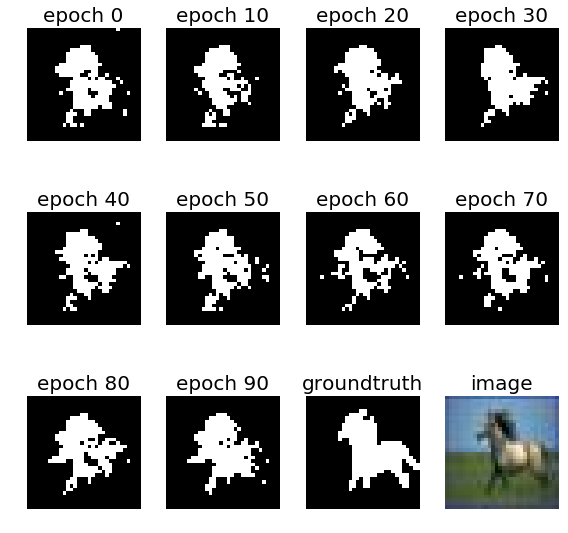

In [60]:
exp_id = 25
stage = 'F:2,G:2,D:2'
lrFGD = '1.0e-03,1.0e-02,1.0e-02'
lambda_x = 1e-2
name = 'xyx_%d_%s_b%d/stage%s/lrFGD%s_lbX%.3f' % (exp_id, opt.dataset, opt.batchSize, stage, lrFGD, lambda_x)
res_dir = os.path.join('../'+opt.checkpoints_dir, name, 'results')
show_img_history(res_dir, 'train', 10)

In [48]:
# stage F
stage_str = 'F:2,G:0,D:0'
lrs = [1e-2, 1e-3, 1e-4]
lb = 1.0

all_ious = []
all_lr_F = [] # 

for j,i in enumerate(valid_experiments):
    name = '%s_%d' % (opt.name, i)
    lst_lrFGD = ['%.1e,%.1e,%.1e' % (lr,lr,lr) for lr in lrs]
    ious,amax = load_max_over_lr(name, lst_lrFGD, lb, stage_str)
    all_ious.append(ious)
    all_lr_F.append(lrs[amax])

F_ious = np.stack(all_ious, axis=0)

In [49]:
# stage GD
stage_str = 'F:1,G:2,D:2'
lr_GD = 1e-4
all_lr_GD = [lr_GD] * len(valid_experiments) #

In [50]:
# stage F2
stage_str = 'F:2,G:1,D:1'
lambda_xs = [100, 10, 1, 1e-1, 1e-2]

all_ious = []
all_lb = [] #

for j,i in enumerate(valid_experiments):
    name = '%s_%d' % (opt.name, i)
    lrFGD = '%.1e,%.1e,%.1e' % (all_lr_F[j],all_lr_GD[j],all_lr_GD[j])
    ious,amax = load_max_over_lb(name, lrFGD, lambda_xs, stage_str)
    all_ious.append(ious)
    all_lb.append(lambda_xs[amax])

F2_ious = np.stack(all_ious, axis=0)

In [51]:
# stage FGD
stage_str = 'F:2,G:2,D:2'
all_ious = []
for j,i in enumerate(valid_experiments):
    name = '%s_%d' % (opt.name, i)
    lb = all_lb[j]
    lr_F = all_lr_F[j]
    lr_GD = all_lr_GD[j]
    lrFGD = '%.1e,%.1e,%.1e' % (lr_F, lr_GD / lb, lr_GD / lb)
    
    ious = load_log(name, stage_str, lrFGD, lb)
    all_ious.append(ious)

FGD_ious = np.stack(all_ious, axis=0)

In [74]:
color_map = dict(F=sns.xkcd_rgb["denim blue"], F2=sns.xkcd_rgb["medium green"], FGD=sns.xkcd_rgb["orange"])

/home/hus/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0, 98.0)

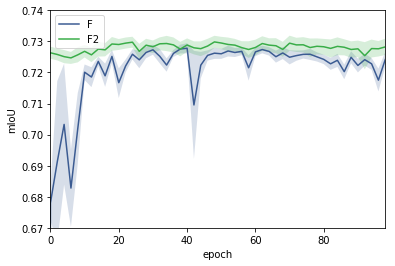

In [75]:
# Comparison between stage F and stage F2

data = np.stack((F_ious, F2_ious), axis=2)
epochs = pd.Series([-1] + list(range(0, opt.niter, 2)), name="epoch")
sns.tsplot(data=data, time=epochs, condition=['F', 'F2'], value='mIoU', color=color_map)
plt.ylim(0.67, 0.74)
plt.xlim(0, None)

/home/hus/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0, 98.0)

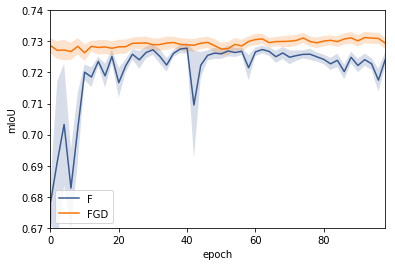

In [76]:
# Comparison between stage F and stage FGD

data = np.stack((F_ious, FGD_ious), axis=2)
epochs = pd.Series([-1] + list(range(0, opt.niter, 2)), name="epoch")
sns.tsplot(data=data, time=epochs, condition=['F', 'FGD'], value='mIoU', color=color_map)
plt.ylim(0.67, 0.74)
plt.xlim(0, None)

/home/hus/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


(0, 98.0)

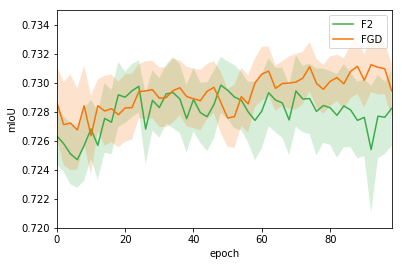

In [79]:
# Comparison between stage F2 and stage FGD

data = np.stack((F2_ious, FGD_ious), axis=2)
epochs = pd.Series([-1] + list(range(0, opt.niter, 2)), name="epoch")
sns.tsplot(data=data, time=epochs, condition=['F2', 'FGD'], value='mIoU', color=color_map)
plt.ylim(0.72, 0.735)
plt.xlim(0, None)